<a href="https://colab.research.google.com/github/abdalazizrashid/Auger-Electron-Spectroscopy/blob/master/Copy_of_XPS_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import glob
import os.path as osp
import re
plt.rcParams['axes.grid'] = True

### Reading asc file

In [0]:
class AesSpec:
    def __init__(self, filename):
    
        #assert filename.endswith('.asc')
        with open(filename, mode='r') as f:
            self.spec_range = f.readline()
            self.meta0 = f.readline()
            self.surv = f.readline()
            self.something = int(f.readline())
            self.ev_min = float(f.readline())
            self.ev_step = float(f.readline())
            self.n_points = int(f.readline())
            self.data = np.zeros(self.n_points)
            for i in range(self.n_points):
                self.data[i] = float(f.readline())
        idx = pd.Index(data=np.linspace(
                                    self.ev_min,
                                    self.ev_min + self.n_points*self.ev_step,
                                    self.n_points),
                       name='eV')
        self.ts = pd.Series(self.data,
                            name=os.path.split(filename)[-1],
                            index=idx)

    @staticmethod
    def all_specs():
        return glob.glob('asc/*-aes.asc')

In [0]:
root_path = "/home/master/Notebook/AES_standard/*"
dataset = []
elements = []
lenght = []
for file in glob.glob(root_path):
    try:
        filename = osp.splitext(osp.split(file)[-1])[0]
        specs = AesSpec(file).ts
        y = specs.iloc[:].to_numpy()
        #x = specs.index.to_numpy()
        elements.append(filename)
        dataset.append(y)
        lenght.append(len(y))
    except:
        print("Error Reading file!")
dataset, elements_array = np.array(dataset), np.array(elements)


elements = []
for i in elements_array:
  d = re.search(r"([a-zA-Z]*)([0-9])*", i)
  elements.append(d.group(1))


711 3191


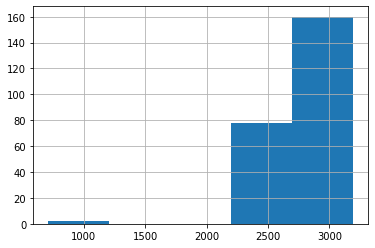

In [4]:
plt.hist(lenght, bins=5)
print(min(lenght), max(lenght))

In [0]:
def smoothdiffS7D7(cnts):
    ''' Create smooth differentiated column from counts using S7D7 PHI algorithm (Multipak tables 
    A-5 and A-1; passing np array (not pandas series)''' 
    numpts=len(cnts)
    endpts=[0,len(cnts)-1] # legacy way of defining endpoints and internal breaks (although those no longer present)
    smooth=[0]*numpts # empty list of correct length for smoothed data
    smoothdiff=[0]*numpts # 7 pt diff of above smoothed data
    # smoothing of endpoints according to Multipak algorithm appendix table A-5    
    for i in range(0,numpts): # special cases for endpoints (within 3 of an evbreak)
        diff=i-min(endpts, key=lambda x:abs(x-i)) # distance from closest evbreak index # in list            
        if diff==0:
            if i==numpts-1: #last point
                smooth[i]=(2*cnts[i]+2*cnts[i-1]+1)/4 # additional special case for last point
            else: # first point
                smooth[i]=(2*cnts[i]+2*cnts[i+1]+1)/4 # all others at exact breaks can use value and adj higher value
        elif abs(diff)==1:  # works for +1 or -1 from nearest break
            smooth[i]=(1*cnts[i-1]+2*cnts[i]+1*cnts[i+1]+1)/4
        elif abs(diff)==2:
            smooth[i]=(-3*cnts[i-2]+12*cnts[i-1]+17*cnts[i]+12*cnts[i+1]+-3*cnts[i+2]+1)/35
        else:
            smooth[i]=(-2*cnts[i-3]+3*cnts[i-2]+6*cnts[i-1]+7*cnts[i]+6*cnts[i+1]+3*cnts[i+2]-2*cnts[i+3]+1)/21

    # Same structure to perform differentiation on smoothed datalist above
    for i in range(0,numpts): # special cases for endpoints (within 3 of an evbreak)
        diff=i-min(endpts, key=lambda x:abs(x-i)) # distance from closest evbreak index # in list
        if abs(diff)<=2:
            smoothdiff[i]=0  # just zero out endpoints (old code moved to python software dev xls cell)
        else:
            smoothdiff[i]=(-3*smooth[i-3]-2*smooth[i-2]-1*smooth[i-1]+1*smooth[i+1]+2*smooth[i+2]+3*smooth[i+3]+1)/28
    smoothdiff=np.asarray(smoothdiff)
    return smoothdiff

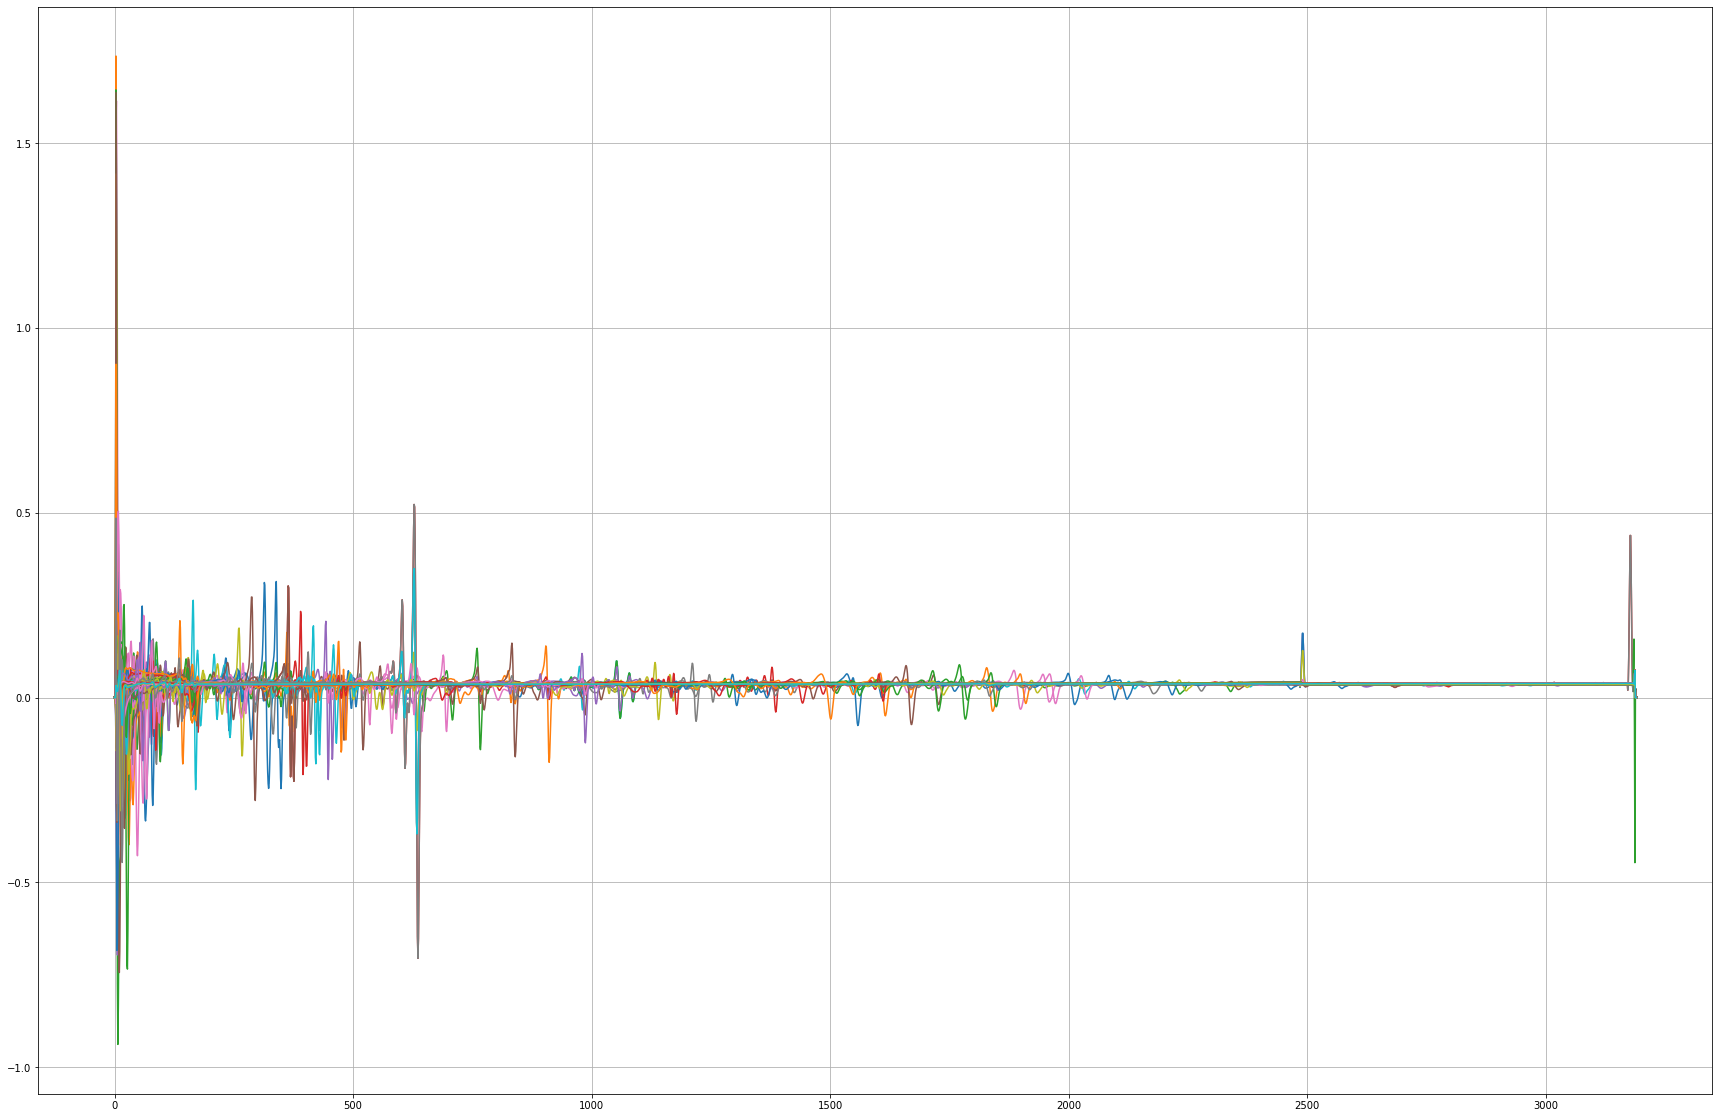

In [6]:
plt.figure(figsize=(30,20))
# Normalize to mean of 0 and standard deviation of 1
def norm(x): return (x-np.mean(x))/np.std(x)

# Normalize to a range between 0, 1
def norm2(x): return (x-np.min(x))/(np.max(x) - np.min(x))

# Padding to respect to the maximum lenght in the dataset
def pad(x):
    shape = ((max(lenght)-len(x)))
    p = np.full(shape, max(x))
    p = np.insert(p, 0, x)
    return p
X = []
Y = []
for i in range(len(dataset)):
    tmp = smoothdiffS7D7(pad(norm(dataset[i])))
    #tmp = pad(norm(dataset[i]))

    plt.plot(tmp)
    Y.append(tmp)
    X.append(np.arange(0, len(tmp)))
#plt.xscale('log')  
#plt.plot(norm(dataset[100]), alpha=0.5, color='r', marker='.')
plt.show()
Y = np.array(Y)
x = np.array(X)


In [0]:
# fig, ax = plt.subplots(len(dataset)//4, 4, figsize = (50, 100))
# plt.grid(True)
# for i in range(len(dataset)):
#     ax.flat[i].plot(dataset[i])
#     ax.flat[i].set_title(elements[i])
#     ax.flat[i].get_xaxis().set_ticks([])
# #fig.savefig("AudioWaveform", dpi=900)     

In [8]:
plt.figure(figsize=(30,10))

def mixture(input_array, num_of_samples=3, parameter=1000):
    mix = np.random.dirichlet(np.ones(num_of_samples)/parameter)
    _y = np.zeros((3191))
    for i in range(num_of_samples):
        print()
        _y += np.sqrt(np.power(np.random.permutation(mix[i] * input_array[i], ), 2))
    return _y


plt.plot(mixture(Y, num_of_samples=, parameter= 1000),'r')
plt.plot(Y[0], '.')
plt.plot(Y[1], '-')
plt.plot(Y[2], '-')
plt.show()


#   mix = np.random.dirichlet(np.ones(num_of_samples)/parameter)
#     _y = np.zeros((3191))
#     for i in range(num_of_samples):
#         print()
#         _y += mix[i] * input_array[i]
#     return _y

SyntaxError: ignored

In [0]:
smth = np.zeros((Y.shape[0], ))
smth1 = np.random.dirichlet(np.ones(3))


In [0]:
plt.plot(smth2)

In [0]:
plt.figure(figsize=(20, 15))
plt.plot(Y[1])
plt.plot(Y[100])
plt.plot(mixture(Y, 3)[0], color='r')
plt.show()

In [0]:
Y.shape

In [0]:
import torch
import re
from torch.utils.data import Dataset, DataLoader
cuda = torch.device('cuda:0')
torch.manual_seed(5)
class Data(Dataset):
   

    def __init__(self, data, name, mixtures=False, n_comps=4, alpha=1.):
        self.mixtures = mixtures
        self.n_comps = n_comps
        self.alpha = alpha
        self.data = data
        self.name = pd.get_dummies(name).to_numpy()
        assert len(name) == len(data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.mixtures:
            components = np.random.permutation(len(self.data))[:self.n_comps]
            gamma = np.ones(self.n_comps) * self.alpha
            small_weights = np.random.dirichlet(gamma)
            weights = np.zeros(len(self.data))
            weights[components] = small_weights
            target = (self.name * weights[:, None]).sum(0)
            y = (self.data * weights[:, None]).sum(0)
            return torch.from_numpy(y).view(1, 3191), target
        else:      
            if torch.is_tensor(idx):
                idx = idx.tolist()
            y = self.data[idx]
            return torch.tensor((y)).view(1, 3191), torch.tensor(self.name[idx]).float()
    
    

In [8]:
np.random.random_integers(1, 50)

/home/master/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(1, 50 + 1) instead
  """Entry point for launching an IPython kernel.


15

In [0]:
bs = 84
trainloader = torch.utils.data.DataLoader(Data(Y, elements, n_comps=np.random.randint(4, 21)), batch_size=bs,
                                         shuffle=True, num_workers=6, pin_memory=False)

In [12]:
import pandas as pd
import wandb
import torch


#90dd838e588a5bce5c551a082a1dfdb39dff7487

wandb.init(project="test")


# s = pd.Series(np.arange(1, 118))
# y = pd.get_dummies(s).to_numpy()
# _y = np.arange(0, 118)
# X = torch.tensor(Y.reshape(1, 3191, -1)).float()
# y = torch.tensor(_y.reshape(1, 118)).float()
# Y = np.random.randint(0, 9, 10).reshape(1, 1, -1)

class Simple1DCNN(torch.nn.Module):
    def __init__(self):
        super(Simple1DCNN, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=128, kernel_size=11, stride=1)
        self.conv2 = torch.nn.Conv1d(in_channels=1, out_channels=128, kernel_size=21, stride=1, padding=5)
        self.conv3= torch.nn.Conv1d(in_channels=1, out_channels=128, kernel_size=41, stride=1, padding=15)
        self.conv4= torch.nn.Conv1d(in_channels=384, out_channels=1024, kernel_size=5, stride=1)### in_channels=384
        self.avg5= torch.nn.AdaptiveAvgPool1d(1)
        self.sigmoid= torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        def relu(x): return x.clamp(0.) - 0.5
        

        self.flatten= torch.nn.Flatten()
        
        # dense layer has 4*512 input dim
        # Contamination
        self.dropout= torch.nn.Dropout(p=0.2)
        self.co_dense1= torch.nn.Linear(in_features=1024, out_features=512)
        self.co_dense2= torch.nn.Linear(in_features=512, out_features=1)
        
        # Quantification
        
        self.qu_dense1= torch.nn.Linear(in_features=1025, out_features=2048)
        self.qu_dense2= torch.nn.Linear(in_features=2048, out_features=84)
        self.norm= torch.nn.LayerNorm((84),elementwise_affine=False)
        
    def forward(self, x):
        f_1_1 = self.relu(self.conv1(x))
        f_1_2 = self.relu(self.conv2(x))
        f_1_3 = self.relu(self.conv3(x))


        t = torch.cat((f_1_1, f_1_2, f_1_3), dim=1)


        f_2 = self.conv4(t)
        f_2 = self.avg5(f_2)
        f_2 = self.flatten(f_2)

        f_3 = self.dropout(f_2)
        f_3 = self.co_dense1(f_3)
        f_3 = self.relu(f_3)
        f_3 = self.co_dense2(f_3)
        

        
        #f_4 = self.dropout(torch.cat((f_3, f_2), dim=1))
        f_4 = torch.cat((f_3, f_2), dim=1)
        f_4 = self.qu_dense1(f_4)
        f_4 = self.relu(f_4)
        f_4 = self.qu_dense2(f_4)
        #f_4 = self.sigmoid(f_4)
        f_4 = self.norm(f_4)



        
        


        return f_4[...,:-1], f_4[...,-1]
    
    



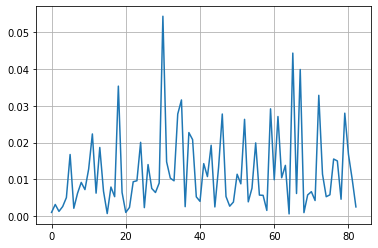

In [13]:
x = next(iter(Data(Y, elements)))[0].view(1, 1, -1).float()

fr = Simple1DCNN().forward(x)[0].detach()#.detach().numpy()
soft = torch.nn.Softmax(dim=-1)
new = soft(fr).numpy()
plt.plot(new.reshape(-1, 1))

In [14]:
cuda = torch.device('cuda:0')

model = Simple1DCNN().to(cuda)

wandb.watch(model)


In [0]:
import math
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [0]:
import torch.distributions.relaxed_categorical
class DickLoss(torch.nn.Module):
  def forward(self, input, temp, target):
    # target = torch.distributions.utils.clamp_probs(target)
    # temp = torch.full_like(temp, 1e-1)
    # dist = torch.distributions.relaxed_categorical.ExpRelaxedCategorical(temp.unsqueeze(-1), logits=input)
    # return -dist.log_prob(target).mean()
    target = target.argmax(-1)
    print(target.shape)
    return torch.nn.CrossEntropyLoss()(
        input, target
    )

class Myloss(torch.nn.Module):
  def forward(self, input, _, target):
    loss = (torch.pow(input, 2) * torch.pow((input - target), 2)).sum()
    return loss 


class Cross_entropy_one_hot(torch.nn.Module):
  def forward(self, input, _, target):
    labels = target.max(dim=1)[1]
    return torch.nn.CrossEntropyLoss()(input, labels)

class KL(torch.nn.Module):
  def forward(self, input, _, target):
    return torch.nn.KLDivLoss(reduction="batchmean",)(input.log(), target)


In [0]:
dirloss = KL()#cross_entropy_one_hot#DickLoss()

In [18]:
p = torch.rand(3, 240)
p /= p.sum(-1, keepdim=True)

smth = torch.tensor(Data(Y, elements, mixtures=True)[0][0]).view(1, 1, -1).float()
sft = torch.nn.Softmax(dim=-1)
ss = sft(Simple1DCNN().forward(smth)[0])
smth1 = torch.tensor(Data(Y, elements, mixtures=True)[0][1])
print(ss)
dirloss(ss, _, smth1)

tensor([[0.0030, 0.0022, 0.0085, 0.0134, 0.0180, 0.0025, 0.0053, 0.0073, 0.0038,
         0.0065, 0.0018, 0.0020, 0.0601, 0.0210, 0.0052, 0.0023, 0.0016, 0.0068,
         0.0069, 0.0098, 0.0087, 0.0078, 0.0012, 0.0136, 0.0066, 0.0430, 0.0038,
         0.0068, 0.0290, 0.0050, 0.0010, 0.0262, 0.0070, 0.0047, 0.0018, 0.0020,
         0.0028, 0.0122, 0.0120, 0.0072, 0.0241, 0.0175, 0.0158, 0.0049, 0.0050,
         0.0094, 0.0049, 0.0220, 0.0190, 0.0132, 0.0019, 0.0066, 0.0194, 0.0139,
         0.0062, 0.0004, 0.0516, 0.0017, 0.0063, 0.0074, 0.0088, 0.0106, 0.0178,
         0.0032, 0.0114, 0.0115, 0.0202, 0.0030, 0.0153, 0.0633, 0.0485, 0.0048,
         0.0077, 0.0309, 0.0091, 0.0026, 0.0052, 0.0080, 0.0043, 0.0307, 0.0152,
         0.0048, 0.0214]], grad_fn=<SoftmaxBackward>)


/home/master/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


tensor(2.7930, dtype=torch.float64, grad_fn=<DivBackward0>)

In [0]:
# from tensorboardX import SummaryWriter
            

# writer = SummaryWriter()

loss_fn = dirloss #cross_entropy_one_hot
learning_rate = 3e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
step_size = 4*len(trainloader)
clr = cyclical_lr(step_size)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

import tqdm


In [0]:
def accuracy(out, yb): 
  return (torch.argmax(out, dim=-1) == torch.argmax(yb, dim=-1)).float().mean()

In [0]:
#wandb.config.update(args)
def update_log(log):
  wandb.log(log)

def train(epoch=100000, trainloader=trainloader):
  cuda = torch.device('cuda:0')
  sf = torch.nn.Softmax(dim=-1)

  log = {"epoch": [], "loss": [], "acc": [], "forward": [], "softMax_forward": [], "feed_x": [], "feed_target": []}

  pre_acc = 0
  with tqdm.tqdm(range(epoch)) as _epochs:
    for epoch in _epochs:
        for i , data in enumerate(trainloader, 0):
            # Forward pass: compute predicted y by passing x to the model.
            x, y = data; 
            log["feed_x"] = x[0]
            log["feed_target"] = y[0]

            x = x.to(cuda)
            y = y.to(cuda)
            
          
            y_pred, t_pred = model(x.float())
            
            
            # Compute and print loss.
            loss = loss_fn(sf(y_pred), t_pred, y)  #Note that i use softmax in the predicted loss

            log["acc"] = acc = accuracy(y_pred, y).item() 

            log["loss"] = loss.item()
            log["feed_x"] = x
            #print(acc)
            optimizer.zero_grad()
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 7)

            optimizer.step()
      
            _epochs.set_description(f"epoch={epoch} acc={acc} loss={loss:.4f}")
        log["epoch"] = epoch
        log["softMax_forward"] = sf(y_pred).cpu().detach().numpy()
        log["forward"] = y_pred.cpu().detach().numpy()

        update_log(log)
        if round(acc, 2) > round(pre_acc, 2):
          checkpoint = {'model': Simple1DCNN(),
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict()}

          torch.save(checkpoint, str(round(acc, 2))+"_mixtures"+"_nodiff_best" +'.pth')
          pre_acc = acc
          print("saved check point")
        




In [24]:
train()

epoch=0 acc=0.9305555820465088 loss=0.1662:   0%|          | 1/100000 [00:06<188:29:58,  6.79s/it]

saved check point


epoch=3 acc=0.944444477558136 loss=0.1678:   0%|          | 4/100000 [00:12<101:20:25,  3.65s/it]

saved check point


epoch=24 acc=0.9722222089767456 loss=0.0989:   0%|          | 25/100000 [01:02<76:12:55,  2.74s/it]

saved check point


epoch=29 acc=0.9861111044883728 loss=0.0934:   0%|          | 30/100000 [01:15<84:10:22,  3.03s/it]

saved check point


epoch=509 acc=1.0 loss=0.0615:   1%|          | 510/100000 [20:56<68:57:34,  2.50s/it]

saved check point


epoch=748 acc=0.9722222089767456 loss=0.0815:   1%|          | 749/100000 [30:29<67:21:25,  2.44s/it]


KeyboardInterrupt: ignored

In [0]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    #for parameter in model.parameters():
     #   parameter.requires_grad = False

    model#.eval()
    return model

model = load_checkpoint('0.99_mixtures_nodiff_best.pth').to(cuda)

tensor(0., device='cuda:0')
[[ 4 33 58 62 52 59 72 49 57 71 47 16 50 80  3 22 51 53 28 64 37 31 10 42
  66  0  5 26  1 14 24 32 40 36  8 11 55 19 73 43 60 61 27 74 78 79 21 13
  25  7 12 30 45  2 82  6 20 23 46 77 70 39 63 15 29 17 54 44 18  9 34 48
  76 75 65 35 38 81 68 41 69 67 56]]
[0.9902704, 0.00020365877, 0.00019467033, 0.00016395526, 0.0001629065, 0.00015702419, 0.00015534805, 0.0001505955, 0.00014557391, 0.00014327955, 0.00014053105, 0.00013857389, 0.00013845038, 0.00013812305, 0.00013590828, 0.00013501328, 0.00013440882, 0.00013357695, 0.00013114985, 0.0001308177, 0.00013044655, 0.00012900257, 0.00012872618, 0.00012829968, 0.00012683941, 0.0001255554, 0.00012536396, 0.0001253325, 0.0001243331, 0.00012311847, 0.00012219019, 0.00012180963, 0.00012179987, 0.00012169432, 0.00012102686, 0.000120981626, 0.00012001633, 0.00011896974, 0.000118700125, 0.000118097516, 0.000115491246, 0.000114716684, 0.000114407936, 0.00011392964, 0.000112982234, 0.00011220054, 0.00011212631, 0.00011159

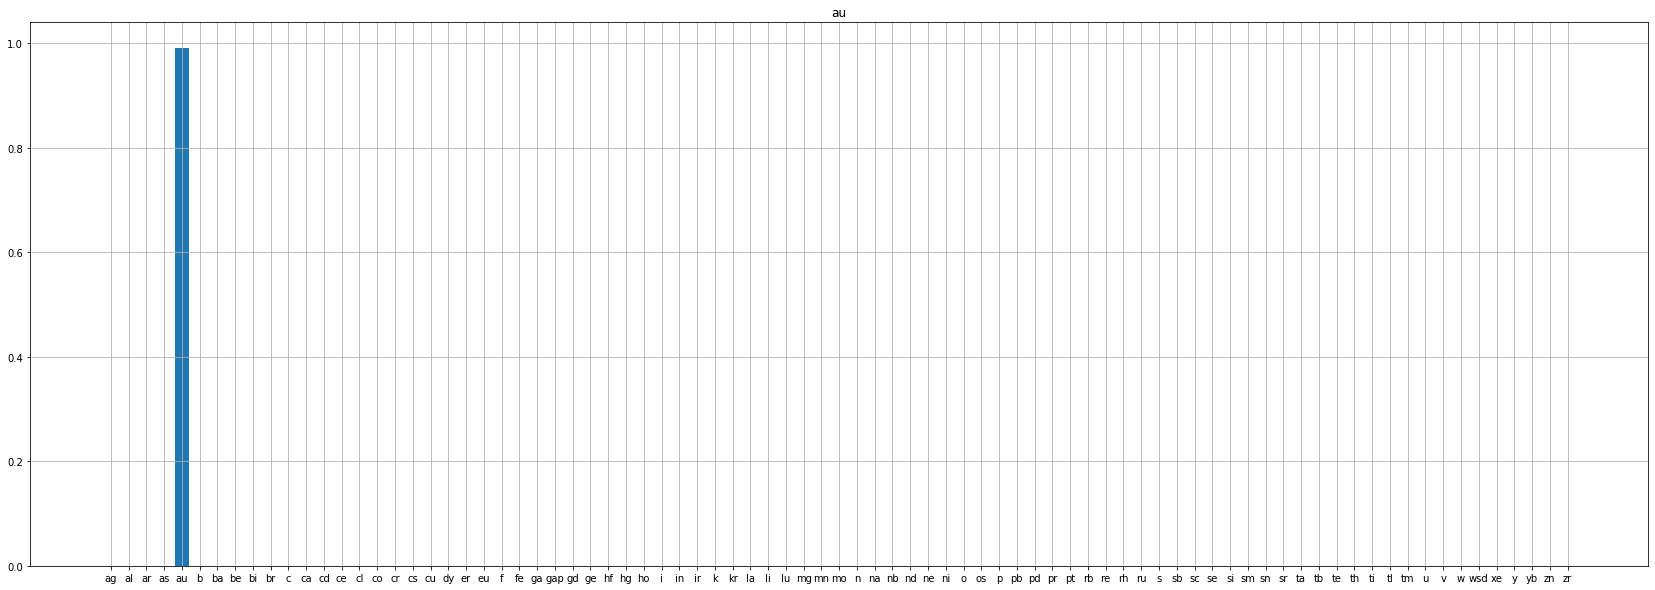

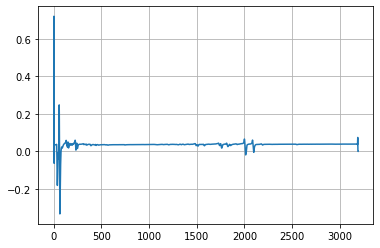

1.0
['au' 'ir' 'ru' 'se' 'pd' 's' 'tl' 'os' 'rh' 'ti' 'ni' 'cr' 'p' 'yb' 'as'
 'f' 'pb' 'pr' 'hf' 'sm' 'li' 'i' 'c' 'n' 'sr' 'ag' 'b' 'gd' 'al' 'cl'
 'ga' 'in' 'mn' 'la' 'bi' 'ca' 'rb' 'dy' 'tm' 'na' 'sb' 'sc' 'ge' 'u' 'xe'
 'y' 'eu' 'ce' 'gap' 'be' 'cd' 'ho' 'nd' 'ar' 'zr' 'ba' 'er' 'fe' 'ne'
 'wsd' 'th' 'mg' 'si' 'co' 'hg' 'cs' 'pt' 'nb' 'cu' 'br' 'k' 'o' 'w' 'v'
 'sn' 'kr' 'lu' 'zn' 'tb' 'mo' 'te' 'ta' 're'] flipped


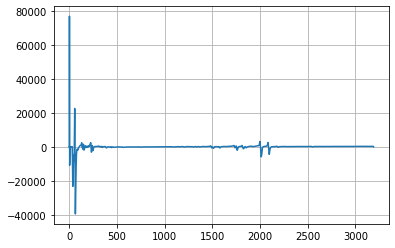

In [52]:
import json
plt.figure(figsize=(29, 10)) 
cuda = torch.device('cuda:0')

data = json.load(open("/home/master/Notebook/AES_DATABASE/json/au10.json"))
infre = torch.tensor(smoothdiffS7D7((norm(pad(data["Specs"])))), device=cuda).float().view(1, 1, -1)
#infre = torch.tensor((pad(norm(data["Specs"]))), device=cuda).float().view(1, 1, -1)


avg = torch.nn.AvgPool1d(kernel_size=21, padding=10, count_include_pad=False, stride=1)

infre = infre


uniq_elements = list(sorted(set(elements)))
idx = 1
#infre = Data(Y, elements)[idx][0].view(1, 1, -1).float().to(cuda)
target = Data(Y, elements)[idx][1]
# print(Data(Y, elements)[idx][2])
results = model.forward(infre)[0]
print(accuracy(results, target))
sx = torch.nn.Softmax(dim=-1)
results = sx(results).cpu().detach().numpy()
plt.bar(uniq_elements, results[0][:])
plt.title(uniq_elements[np.argmax(results)])
print(np.flip(np.argsort(results)))
print(sorted(results[0], reverse=True))
plt.show()



plt.plot(infre.cpu().numpy()[0].reshape(-1, 1))
plt.show()
plt.plot(smoothdiffS7D7(data["Specs"]))
print(results.sum())



#########################
exs = []
for item in np.argsort(results)[0]:
  exs.append((sorted(set(elements))[item]))
print(np.flip(exs), "flipped")


In [0]:
print(results[0].shape)
len(set(elements))

(83,)


83

In [0]:
sorted(set(elements))[81]

'zn'

In [0]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

In [0]:
dump_tensors()

/home/master/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/master/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Float64Index.data is deprecated and will be removed in a future version
/usr/local/anaconda/envs/fastai/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "
wandb: WARNING import wandb.keras called before import keras or import tensorflow.keras.  This can lead to a version mismatch, W&B now assumes tensorflow.keras


Tensor: GPU pinned 240 × 1 × 3191
Tensor: GPU pinned 240 × 83
Tensor: GPU pinned 240 × 1 × 3191
Tensor: GPU pinned 240 × 128 × 3181
Tensor: GPU pinned 240 × 128 × 3181
Tensor: GPU pinned 240 × 128 × 3181
Tensor: GPU pinned 240 × 384 × 3181
Parameter: GPU pinned 128 × 1 × 11
Parameter: GPU pinned 128
Parameter: GPU pinned 128 × 1 × 21
Parameter: GPU pinned 128
Parameter: GPU pinned 128 × 1 × 41
Parameter: GPU pinned 128
Parameter: GPU pinned 1024 × 384 × 5
Parameter: GPU pinned 1024
Parameter: GPU pinned 512 × 1024
Parameter: GPU pinned 512
Parameter: GPU pinned 1 × 512
Parameter: GPU pinned 1
Parameter: GPU pinned 2048 × 1025
Parameter: GPU pinned 2048
Parameter: GPU pinned 84 × 2048
Parameter: GPU pinned 84
Tensor: GPU pinned 240 × 1 × 3191
Tensor: GPU pinned 240 × 83
Tensor: GPU pinned 240 × 83
Tensor: GPU pinned 240
Tensor: GPU pinned 
Total size: 593454950


In [0]:
torch.cuda.empty_cache()

In [0]:
model = None

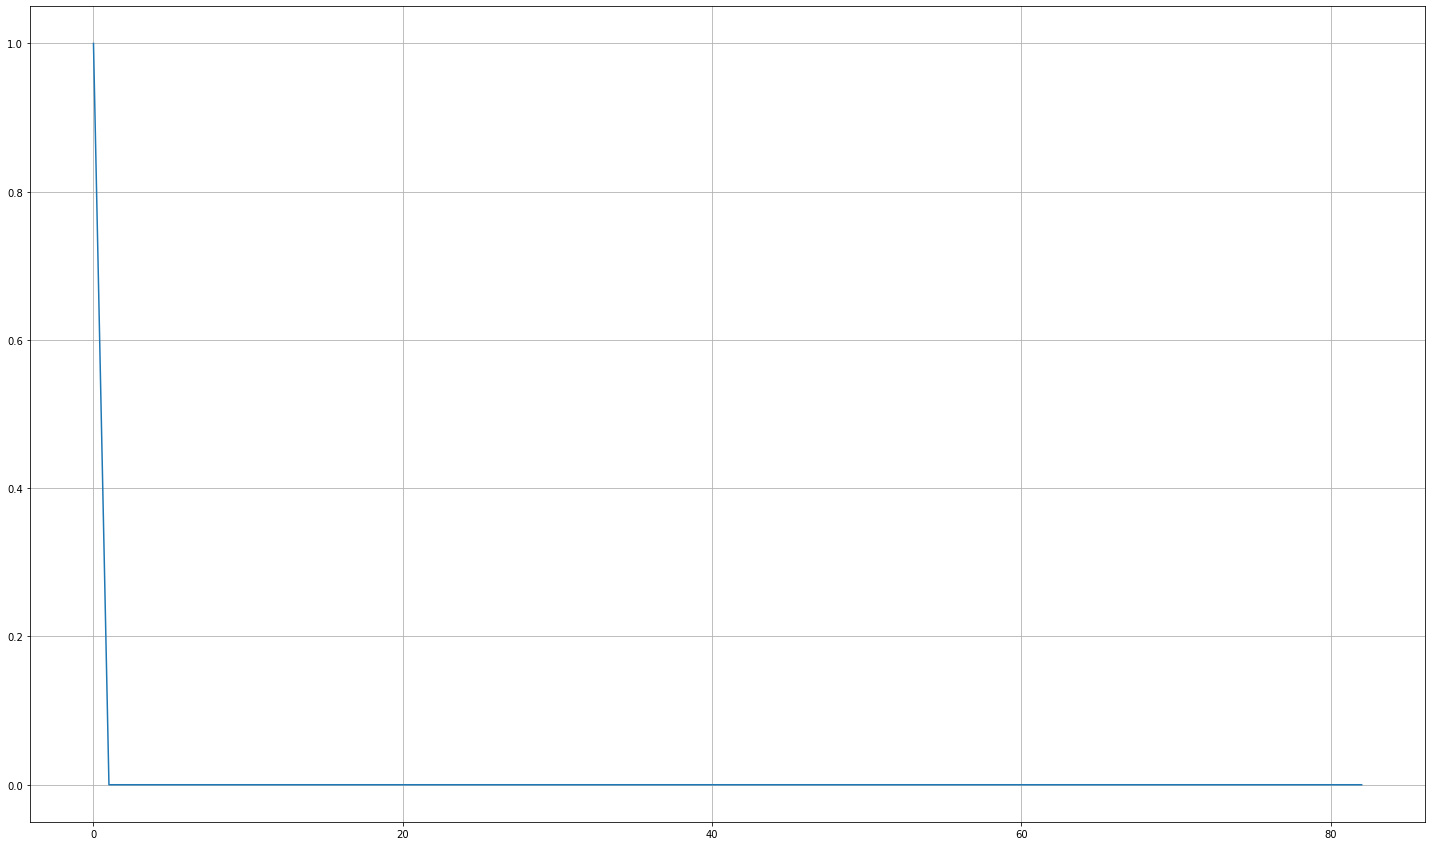

In [0]:
plt.figure(figsize=(25, 15))
for i in Data(Y, elements):
  plt.plot(i[1].numpy().reshape(-1, 1))
  #plt.plot(i[0].numpy().reshape(-1, 1))
  break

In [0]:
i[1].argmax()

tensor(0)